In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (update path as needed)
file_path = "Freight_Cost_Analysis_CY2024-03.25.csv"
df = pd.read_csv(file_path, encoding="latin1", low_memory=False)


In [2]:

# Step 1: Freight Spend Profiling
freight_lines = df[df['ACCOUNT DESCRIPTION'].astype(str).str.upper().str.contains('PROJECT FREIGHT', na=False)]
total_po_value = df.groupby('PO NO', as_index=False)['INVOICE LINE TOTAL'].sum().rename(columns={'INVOICE LINE TOTAL': 'TOTAL_PO_VALUE'})
freight_cost = freight_lines.groupby('PO NO', as_index=False)['INVOICE LINE TOTAL'].sum().rename(columns={'INVOICE LINE TOTAL': 'PROJECT_FREIGHT_COST'})
df = df.merge(total_po_value, on='PO NO', how='left')
df = df.merge(freight_cost, on='PO NO', how='left')
df['PROJECT_FREIGHT_COST'] = df['PROJECT_FREIGHT_COST'].fillna(0)
df['PROJECT_FREIGHT_PERCENT'] = df['PROJECT_FREIGHT_COST'] / df['TOTAL_PO_VALUE']
df['PRODUCT_ONLY_PO_VALUE'] = df['TOTAL_PO_VALUE'] - df['PROJECT_FREIGHT_COST']
df['FREIGHT_PERCENT_EXCL_PRODUCT'] = df['PROJECT_FREIGHT_COST'] / df['PRODUCT_ONLY_PO_VALUE']
df['FREIGHT_≥90%_OF_PO'] = df['PROJECT_FREIGHT_PERCENT'] >= 0.9
df['FREIGHT_GT_PRODUCT'] = df['PROJECT_FREIGHT_COST'] > df['PRODUCT_ONLY_PO_VALUE']
df['NEGATIVE_FREIGHT_PERCENT'] = df['PROJECT_FREIGHT_PERCENT'] < 0

# Step 2: ZIP & Supplier Analysis
df['SHIP TO ZIP'] = df['SHIP TO ZIP'].astype(str).str.extract(r'(\d{5})')
freight_df = df[df['PROJECT_FREIGHT_COST'] > 0]
zip_supplier_summary = freight_df.groupby(['SHIP TO ZIP', 'SUPPLIER NO']).agg(
    AVG_FREIGHT_PERCENT=('PROJECT_FREIGHT_PERCENT', 'mean'),
    PO_COUNT=('PO NO', 'nunique')
).reset_index()
zip_supplier_summary['HIGH_FREIGHT_FLAG'] = zip_supplier_summary['AVG_FREIGHT_PERCENT'] > 0.5
df = df.merge(zip_supplier_summary[['SHIP TO ZIP', 'SUPPLIER NO', 'HIGH_FREIGHT_FLAG']],
              on=['SHIP TO ZIP', 'SUPPLIER NO'], how='left')

# Step 3: Product Analysis
labor_keywords = ['LABOR', 'INSTALL', 'SERVICE', 'WAGE', 'CONTRACT', 'EMPLOYEE']
df['PART DESCRIPTION CLEAN'] = df['PART DESCRIPTION'].astype(str).str.upper()
df['IS_LABOR'] = df['PART DESCRIPTION CLEAN'].apply(lambda desc: any(k in desc for k in labor_keywords))
product_counts = df[~df['IS_LABOR'] & df['PART DESCRIPTION'].notna()].groupby('PART DESCRIPTION').size().reset_index(name='PRODUCT_ORDER_COUNT')
product_counts['PRODUCT_ORDER_RANK'] = product_counts['PRODUCT_ORDER_COUNT'].rank(method='dense', ascending=False).astype(int)
df = df.merge(product_counts, on='PART DESCRIPTION', how='left')

# Step 4: UOM Consistency
def compare_uom(row):
    if pd.isna(row['INV UOM']):
        return 'Missing INV UOM'
    elif row['PURCH UOM'] == row['INV UOM']:
        return 'Match'
    else:
        return 'Mismatch'
df['UOM_COMPARISON_STATUS'] = df.apply(compare_uom, axis=1)

# Step 5: Key Metrics Summary (optional print)
po_summary = df[['PO NO', 'PROJECT_FREIGHT_COST', 'PRODUCT_ONLY_PO_VALUE']].drop_duplicates().dropna()
po_summary['FREIGHT_PERCENT_EXCL_PRODUCT'] = po_summary['PROJECT_FREIGHT_COST'] / po_summary['PRODUCT_ONLY_PO_VALUE']
pct_le_10 = (po_summary['FREIGHT_PERCENT_EXCL_PRODUCT'] <= 0.10).mean() * 100
pct_gt_50 = (po_summary['FREIGHT_PERCENT_EXCL_PRODUCT'] > 0.50).mean() * 100
print(f"% of POs with freight ≤ 10% of product spend: {pct_le_10:.2f}%")
print(f"% of POs with freight > 50% of product spend: {pct_gt_50:.2f}%")

# Step 6: Composite Key Consistency
df['PO_INVOICE_COMPOSITE_KEY'] = df['PO NO'].astype(str) + '|' + df['INVOICE ID'].astype(str) + '|' + df['INVOICE NO'].astype(str)
composite_counts = df.groupby('PO NO')['PO_INVOICE_COMPOSITE_KEY'].nunique().reset_index()
composite_counts['PO_COMPOSITE_KEY_CONSISTENCY'] = composite_counts['PO_INVOICE_COMPOSITE_KEY'].apply(lambda x: 'Consistent' if x == 1 else 'Inconsistent')
df = df.merge(composite_counts[['PO NO', 'PO_COMPOSITE_KEY_CONSISTENCY']], on='PO NO', how='left')



# # Export enriched dataset
# output_path = "Freight_Analysis_Enriched_Output.csv"
# df.to_csv(output_path, index=False)
# print(f"\n✅ Enriched dataset exported to: {output_path}")


% of POs with freight ≤ 10% of product spend: 87.67%
% of POs with freight > 50% of product spend: 2.61%


In [11]:
dff = df[df['SITE']=='DIT']
dff.head(2)

,SITE,SITE DESCRIPTION,SUPPLIER NO,SUPPLIER NAME,INVOICE ID,INVOICE NO,DATE POSTED,PROJECT ID,PROJECT NAME,ACCOUNT,...,FREIGHT_GT_PRODUCT,NEGATIVE_FREIGHT_PERCENT,HIGH_FREIGHT_FLAG,PART DESCRIPTION CLEAN,IS_LABOR,PRODUCT_ORDER_COUNT,PRODUCT_ORDER_RANK,UOM_COMPARISON_STATUS,PO_INVOICE_COMPOSITE_KEY,PO_COMPOSITE_KEY_CONSISTENCY
49292,DIT,Diverzify Itasca,101928,VAN GELDER INC,430794,267481-00 48431,2-Jan-24,2309113311,River Center Entry Mats,2008,...,False,False,False,VAN GELDER MEDIUM PROFILE EDGING (30390070MP) ...,False,1.0,129.0,Match,48431|430794|267481-00 48431,Consistent
49293,DIT,Diverzify Itasca,101928,VAN GELDER INC,430803,267481-00 DIT39490,2-Jan-24,2309113311,River Center Entry Mats,2008,...,False,False,False,VAN GELDER\PLAIN EAGLE MAT CUSTOM\BEIGE\MEDIUM...,False,1.0,129.0,Match,DIT39490|430803|267481-00 DIT39490,Consistent


In [12]:
dff.to_csv('Freight_Analysis_Enriched_DIT.csv', index=False)

In [3]:
# Step 7: Isolate for product  
df['COMM 1'] = df['COMM 1'].astype(str).str.strip()
product_df = df[
    df['COMM 1'].notna() & 
    (df['COMM 1'].str.upper() != '0') & 
    (df['COMM 1'].str.upper() != 'nan')]
product_df['COMM 1'].isna().sum()

product_df = product_df[product_df['ACCOUNT']== 2008]
product_df['Type'] = 'Material'
product_df.head(20)


,SITE,SITE DESCRIPTION,SUPPLIER NO,SUPPLIER NAME,INVOICE ID,INVOICE NO,DATE POSTED,PROJECT ID,PROJECT NAME,ACCOUNT,...,NEGATIVE_FREIGHT_PERCENT,HIGH_FREIGHT_FLAG,PART DESCRIPTION CLEAN,IS_LABOR,PRODUCT_ORDER_COUNT,PRODUCT_ORDER_RANK,UOM_COMPARISON_STATUS,PO_INVOICE_COMPOSITE_KEY,PO_COMPOSITE_KEY_CONSISTENCY,Type
1,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL PRE-NOTCHED Z-BAR INSIDE CORNER AL...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
2,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL Z BAR DARK GRAY VINYL COVE CAP 8' ...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
5,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL CLASSIC 5FT X 8FT MATTE - DARK GRA...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
6,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL SPECIALTY FLOORING VINYL COVE BASE...,False,18.0,112.0,Match,48180|433340|173373,Inconsistent,Material
7,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL NON RAPID WELD APPLICATIONS SEAM S...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
8,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,OSCODA PLASTICS 490 ML RAPID WELD/1 TUBE 1 NOZ...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
9,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL 295 URETHANE ADHESIVE 2 GAL (850395),False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
11,BNB,Beckers New Brighton,104716,Hank's Specialties,433229,173374,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,JHN G1 CTA-XX-A - BLACK(40),False,35.0,95.0,Match,48180|433229|173374,Inconsistent,Material
13,BNB,Beckers New Brighton,104716,Hank's Specialties,433229,173374,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL RAPID SEAM TAPE (865045) 1 ROLL,False,1.0,129.0,Match,48180|433229|173374,Inconsistent,Material
14,BNB,Beckers New Brighton,104716,Hank's Specialties,433221,173686,3-Jan-24,2312128839,GRADIENT -SMALL REMODEL,2008,...,False,False,JOHNSONITE VINYL (CB-XX) COVE COIL 4IN 1/8IN -...,False,19.0,111.0,Match,47721|433221|173686,Consistent,Material


In [4]:
# Step 7: Isolate for freight  
freight_df = df[(df['ACCOUNT'] == 5504) & 
            (df['PO NO'].notna()) & 
            (df['PO NO'].astype(str).str.strip() !='0') & 
            (df['INVOICE LINE TOTAL'] > 0)]
freight_df['Type'] = 'Freight'
freight_df.head(5)


C:\Users\nzhuw\AppData\Local\Temp\ipykernel_13584\148963052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freight_df['Type'] = 'Freight'


,SITE,SITE DESCRIPTION,SUPPLIER NO,SUPPLIER NAME,INVOICE ID,INVOICE NO,DATE POSTED,PROJECT ID,PROJECT NAME,ACCOUNT,...,NEGATIVE_FREIGHT_PERCENT,HIGH_FREIGHT_FLAG,PART DESCRIPTION CLEAN,IS_LABOR,PRODUCT_ORDER_COUNT,PRODUCT_ORDER_RANK,UOM_COMPARISON_STATUS,PO_INVOICE_COMPOSITE_KEY,PO_COMPOSITE_KEY_CONSISTENCY,Type
3,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,5504,...,False,NaN,NAN,False,NaN,NaN,Missing INV UOM,48180|433340|173373,Inconsistent,Freight
33,BNB,Beckers New Brighton,103423,"Shaw Industries, Inc.",443411,9389619,10-Jan-24,2312128562,Polar Automotive Warehouse,5504,...,False,NaN,NAN,False,NaN,NaN,Missing INV UOM,47278|443411|9389619,Consistent,Freight
44,BNB,Beckers New Brighton,426,"WALCRO, LLC",444070,337207,11-Jan-24,2308111280,Winthrop & Weinstine,5504,...,False,NaN,NAN,False,NaN,NaN,Missing INV UOM,49656|444070|337207,Consistent,Freight
50,BNB,Beckers New Brighton,107786,Dal Tile Corporation,449689,141972000,15-Jan-24,2312126400,Cargill Office Center Patches,5504,...,False,NaN,NAN,False,NaN,NaN,Missing INV UOM,44346|449689|141972000,Consistent,Freight
53,BNB,Beckers New Brighton,890,All Surfaces,459819,5397546,22-Jan-24,2308111280,Winthrop & Weinstine,5504,...,False,NaN,NAN,False,NaN,NaN,Missing INV UOM,54121|459819|5397546,Consistent,Freight


In [7]:
# Merged on PO just frieght and product 
common_po_nos = set(product_df['PO NO']).intersection(set(freight_df['PO NO']))
filteredP_df = product_df[product_df['PO NO'].isin(common_po_nos)]
filteredF_df = freight_df[freight_df['PO NO'].isin(common_po_nos)]
final_df = pd.concat([filteredP_df, filteredF_df], ignore_index=True)

 

In [8]:
# Remove manual lines (Po Ref Number)
man_df = pd.read_excel('Manual Lines .xlsx')
man_po = man_df['Po Ref Number'].astype(str).str.strip()
no_man_df = final_df [~final_df['PO NO'].astype(str).str.strip().isin(man_po)]
no_man_df.head()

,SITE,SITE DESCRIPTION,SUPPLIER NO,SUPPLIER NAME,INVOICE ID,INVOICE NO,DATE POSTED,PROJECT ID,PROJECT NAME,ACCOUNT,...,NEGATIVE_FREIGHT_PERCENT,HIGH_FREIGHT_FLAG,PART DESCRIPTION CLEAN,IS_LABOR,PRODUCT_ORDER_COUNT,PRODUCT_ORDER_RANK,UOM_COMPARISON_STATUS,PO_INVOICE_COMPOSITE_KEY,PO_COMPOSITE_KEY_CONSISTENCY,Type
0,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL PRE-NOTCHED Z-BAR INSIDE CORNER AL...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
1,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL Z BAR DARK GRAY VINYL COVE CAP 8' ...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
2,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL CLASSIC 5FT X 8FT MATTE - DARK GRA...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material
3,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL SPECIALTY FLOORING VINYL COVE BASE...,False,18.0,112.0,Match,48180|433340|173373,Inconsistent,Material
4,BNB,Beckers New Brighton,104716,Hank's Specialties,433340,173373,3-Jan-24,2312127706,UOFM MOLECULAR & CELLULAR BIOLOGY P,2008,...,False,False,PROTECT ALL NON RAPID WELD APPLICATIONS SEAM S...,False,1.0,129.0,Match,48180|433340|173373,Inconsistent,Material


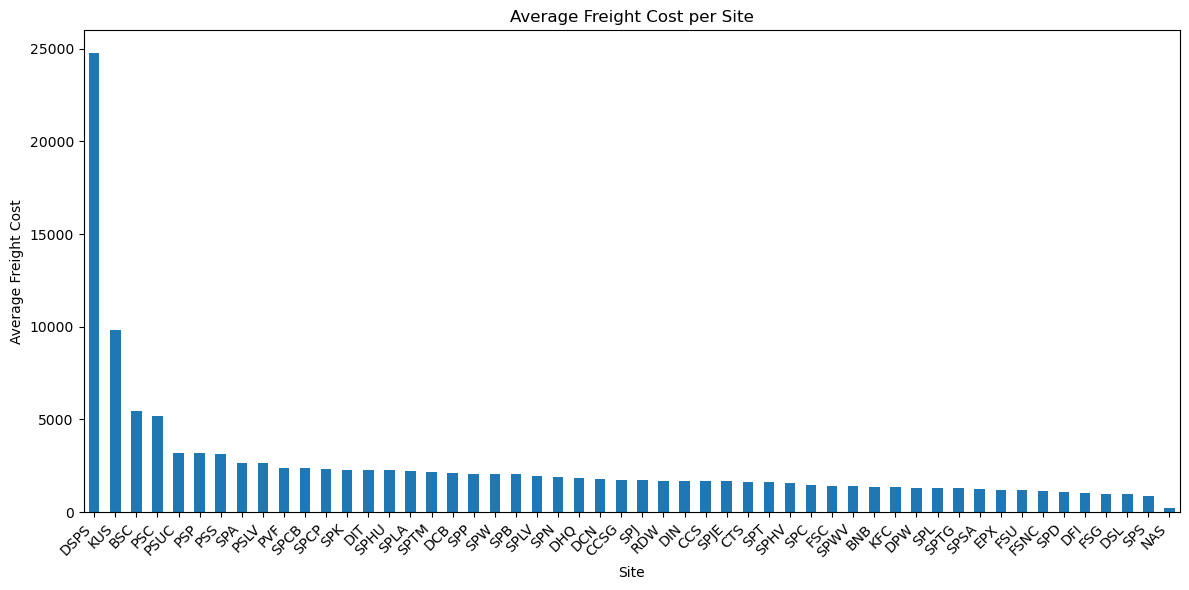

C:\Users\nzhuw\AppData\Local\Temp\ipykernel_13584\977676949.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_man_df['SHIP TO ZIP'] = no_man_df['SHIP TO ZIP'].astype(str).str.extract(r'(\d{5})')


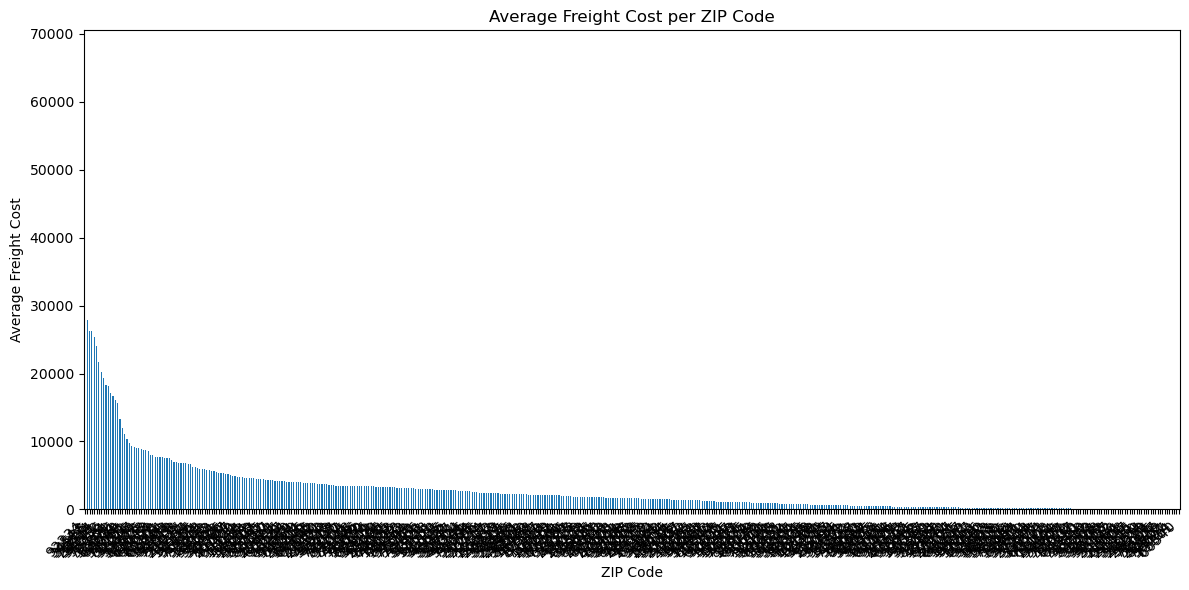

Actual average freight cost per PO: $6,145.85


In [9]:
 # a. Distribution of average freight cost per sit
avg_freight_by_site = no_man_df.groupby('SITE')['INVOICE LINE TOTAL'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_freight_by_site.plot(kind='bar')
plt.title('Average Freight Cost per Site')
plt.ylabel('Average Freight Cost')
plt.xlabel('Site')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# b. Distribution of average freight cost per ZIP code
no_man_df['SHIP TO ZIP'] = no_man_df['SHIP TO ZIP'].astype(str).str.extract(r'(\d{5})')
avg_freight_by_zip = no_man_df.groupby('SHIP TO ZIP')['INVOICE LINE TOTAL'].mean().dropna().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_freight_by_zip.plot(kind='bar')
plt.title('Average Freight Cost per ZIP Code')
plt.ylabel('Average Freight Cost')
plt.xlabel('ZIP Code')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# c. Actual average freight cost per PO
avg_freight_per_po = no_man_df.groupby('PO NO')['INVOICE LINE TOTAL'].sum().mean()
print(f"Actual average freight cost per PO: ${avg_freight_per_po:,.2f}")

In [10]:
# Export dataset
output_path = "Freight_Analysis_PO_02_04_2025.csv"
no_man_df.to_csv(output_path, index=False)
print(f"\n✅ Enriched dataset exported to: {output_path}")


✅ Enriched dataset exported to: Freight_Analysis_PO_02_04_2025.csv
